## Model Selection (Initial Experimentation)

### For embeddings:

- **FinBERT**: Creates highly accurate semantic embeddings (dense vectors) because it is fine-tuned on financial text, allowing it to capture the subtle contextual meaning of financial terms and phrases that general models miss, which is crucial for forming semantically coherent clusters of financial documents.

- **TF-IDF**: Generates a highly efficient, interpretable sparse vector by assigning a weight to each word based on its importance (high frequency in one document, low frequency across the corpus), making it computationally cheap and excellent for keyword extraction and quickly identifying terms that are unique and distinguishing for a given document.


### For clustering:

- **K Means Clustering** - K-Means is highly scalable and fast due to its low computational complexity, making it the most efficient choice for clustering very large datasets of financial vectors where processing speed is a priority.

- **Gaussian Mixture Models** - GMM offers soft assignment by providing the probability of a vector belonging to every cluster, and it can accurately model clusters that are non-spherical or have varying densities, which is beneficial when an article partially belongs to multiple financial topics.


In [1]:
IN_FILE_PATH = "./data/gnews.csv"
OUT_FILE_PATH = "./data/cluster/gnews_gmm.csv"
TEXT_COL = "summary"
N_CLUSTER = 10

In [2]:
"""
Clustering news articles with FinBERT embeddings + GMM
"""

# pip install pandas numpy scikit-learn scipy matplotlib seaborn transformers torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from transformers import AutoTokenizer, AutoModel
from numpy.linalg import inv, LinAlgError
from scipy.spatial.distance import mahalanobis
from sklearn.mixture import GaussianMixture
from typing import List, Optional, Tuple, Any
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from dataclasses import dataclass

# ------------------------
# FinBERT embeddings + GMM clustering
# ------------------------

@dataclass
class FinbertGMMConfig:
    model_name: str = "ProsusAI/finbert"
    max_tokens: int = 256
    batch_size: int = 16
    pca_components: int = 50
    n_components: int = 20   # GMM components (clusters)
    covariance_type: str = "full"
    random_state: int = 0


class FinbertEmbedder:
    def __init__(self, model_name: str, max_tokens: int = 256, device: Optional[str] = None):
        self.model_name = model_name
        self.max_tokens = max_tokens

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

        if device is None:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device

        self.model.to(self.device)
        self.model.eval()

    @torch.no_grad()
    def encode_batch(self, texts: List[str]) -> np.ndarray:
        """Encode a batch of texts into embeddings."""
        enc = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=self.max_tokens,
            return_tensors="pt"
        ).to(self.device)

        outputs = self.model(**enc)
        last_hidden = outputs.last_hidden_state  # (batch, seq_len, hidden)
        attention_mask = enc["attention_mask"].unsqueeze(-1)  # (batch, seq_len, 1)

        # masked mean pooling
        masked = last_hidden * attention_mask
        sum_embeddings = masked.sum(dim=1)  # (batch, hidden)
        lengths = attention_mask.sum(dim=1)  # (batch, 1)
        mean_embeddings = sum_embeddings / (lengths + 1e-9)

        return mean_embeddings.cpu().numpy()

    def encode_corpus(self, texts: List[str], batch_size: int = 16) -> np.ndarray:
        """Encode a full corpus with batching."""
        all_embs = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            embs = self.encode_batch(batch)
            all_embs.append(embs)
        return np.vstack(all_embs)


class FinbertGMMClustering:
    def __init__(self, config: FinbertGMMConfig):
        self.config = config
        self.embedder: Optional[FinbertEmbedder] = None
        self.pca: Optional[PCA] = None
        self.gmm: Optional[GaussianMixture] = None

    def fit(self, texts: List[str]) -> Tuple[np.ndarray, np.ndarray, GaussianMixture]:
        """
        Fit FinBERT embeddings + PCA + GMM on texts.
        Returns:
            cluster_ids: (N,) array of cluster labels
            Z: (N, p) PCA-reduced embeddings (for future use)
        """
        # 1) embeddings
        self.embedder = FinbertEmbedder(
            model_name=self.config.model_name,
            max_tokens=self.config.max_tokens
        )
        X_emb = self.embedder.encode_corpus(
            texts,
            batch_size=self.config.batch_size
        )
        print(f"[FinBERT] Embedded shape: {X_emb.shape}")

        # 2) PCA
        self.pca = PCA(n_components=self.config.pca_components, random_state=self.config.random_state)
        Z = self.pca.fit_transform(X_emb)
        print(f"[FinBERT] PCA-reduced shape: {Z.shape}")

        # 3) GMM
        self.gmm = GaussianMixture(
            n_components=self.config.n_components,
            covariance_type=self.config.covariance_type,
            random_state=self.config.random_state
        )
        self.gmm.fit(Z)
        cluster_ids = self.gmm.predict(Z)

        try:
            sil = silhouette_score(Z, cluster_ids, metric="euclidean")
            print(f"[FinBERT+GMM] Silhouette (euclidean): {sil:.3f}")
        except Exception as e:
            print(f"[FinBERT+GMM] Could not compute silhouette: {e}")

        return cluster_ids, Z, self.gmm

    def predict(self, new_texts: List[str]) -> Tuple[np.ndarray, np.ndarray]:
        """
        Assign clusters to new texts.
        Returns:
            cluster_ids: (M,) labels
            probs: (M, K) cluster probabilities
        """
        if self.embedder is None or self.pca is None or self.gmm is None:
            raise RuntimeError("Model not fitted yet.")

        X_emb_new = self.embedder.encode_corpus(new_texts, batch_size=self.config.batch_size)
        Z_new = self.pca.transform(X_emb_new)
        cluster_ids = self.gmm.predict(Z_new)
        probs = self.gmm.predict_proba(Z_new)
        return cluster_ids, probs




In [3]:

# ------------------------
# Utilities
# ------------------------

def basic_clean(text: str) -> str:
    """Very light cleaning. You can extend this if needed."""
    if not isinstance(text, str):
        return ""
    # strip whitespace, collapse spaces; keep case/nums because they are informative
    text = text.strip()
    text = " ".join(text.split())
    return text

def load_texts_from_csv(path: str = IN_FILE_PATH, text_column: str = TEXT_COL) -> List[str]:
    df = pd.read_csv(path)
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in CSV.")
    texts = [basic_clean(t) for t in df[text_column].astype(str).tolist()]
    return texts, df

def calculate_gmm_mahalanobis_risk(gmm_model: GaussianMixture, X: np.ndarray) -> np.ndarray:
    """
    Calculates the Mahalanobis Distance for every article in X,
    using the parameters of its assigned GMM cluster.
    """
    # 1. Get Cluster Assignments (k)
    cluster_assignments = gmm_model.predict(X)

    # 2. Get GMM Parameters (mu_k and Sigma_k)
    all_means = gmm_model.means_
    all_covariances = gmm_model.covariances_

    risk_scores = np.full(X.shape[0], np.nan)

    # --- Iterate through all unique clusters ---
    for k in np.unique(cluster_assignments):
        cluster_indices = np.where(cluster_assignments == k)[0]
        cluster_mean = all_means[k]
        cluster_covariance = all_covariances[k]

        try:
            # Calculate the Inverse Covariance Matrix (VI)
            inv_covariance = inv(cluster_covariance)

            # Calculate Mahalanobis Distance for all points in this cluster
            for i in cluster_indices:
                article_vector = X[i]

                distance = mahalanobis(
                    article_vector,
                    cluster_mean,
                    inv_covariance
                )
                risk_scores[i] = distance

        except LinAlgError:
            # Skip if the matrix is singular (happens often with small clusters and 'full' covariance)
            print(f"Warning: Cluster {k} covariance matrix is singular. Skipping.")
            continue

    return risk_scores

def create_visualization(Z_data: np.ndarray, df: pd.DataFrame):
    """
    Runs PCA on the existing 20-component data (Z) to get a 2D projection
    for visualization, then creates a scatter plot colored by GMM cluster ID.
    """

    # 1. Run PCA to reduce the data from 20 dimensions (Z) down to 2 dimensions (2D)
    # uses the data already processed by the FinBERT pipeline.
    pca_plot = PCA(n_components=2, random_state=0)
    Z_pca_2d = pca_plot.fit_transform(Z_data)

    # 2. Add the 2D coordinates to the DataFrame
    df['pca_x'] = Z_pca_2d[:, 0]
    df['pca_y'] = Z_pca_2d[:, 1]

    # 3. Create Visualization
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='pca_x',
        y='pca_y',
        hue='cluster_finbert_gmm', # Use the FinBERT cluster ID for color
        palette='tab10',
        data=df,
        legend='full',
        s=70,
        alpha=0.7
    )

    plt.title('2D PCA Visualization of FinBERT GMM Clusters', fontsize=14)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc=2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Loaded 400 articles.

=== FinBERT + GMM ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

[FinBERT] Embedded shape: (400, 768)
[FinBERT] PCA-reduced shape: (400, 20)
[FinBERT+GMM] Silhouette (euclidean): 0.264


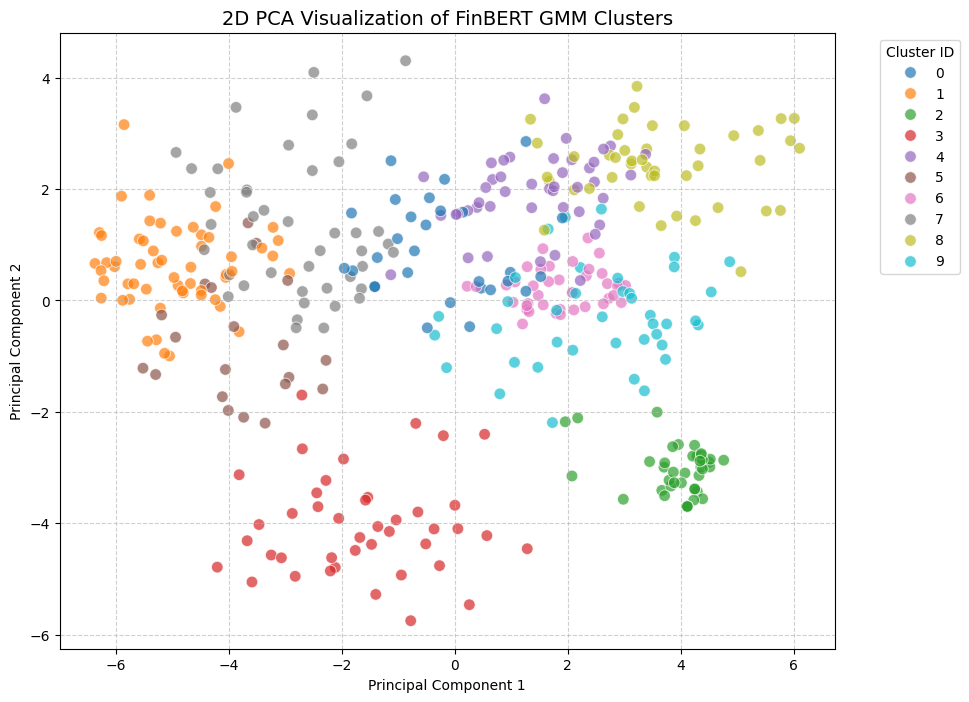


Saved clustered data to: gnews_with_clusters.csv


In [4]:
def main():
    texts, df = load_texts_from_csv(IN_FILE_PATH, text_column=TEXT_COL)
    print(f"Loaded {len(texts)} articles.")

    # -------------------------------------
    # Cluster
    # -------------------------------------
    print("\n=== FinBERT + GMM ===")
    finbert_cfg = FinbertGMMConfig(
        model_name="ProsusAI/finbert",
        max_tokens=256,
        batch_size=8,
        pca_components=N_CLUSTER*2,
        n_components=N_CLUSTER,
        covariance_type="full",
        random_state=0
    )
    finbert_model = FinbertGMMClustering(finbert_cfg)
    finbert_clusters, Z, gmm_sim = finbert_model.fit(texts)
    df["cluster_finbert_gmm"] = finbert_clusters


    # -------------------------------------
    # Risk calculation
    # -------------------------------------
    risk_scores = calculate_gmm_mahalanobis_risk(gmm_sim, Z)
    df["mahalanobis_risk_score"] = risk_scores


    # -------------------------------------
    # Visualization
    # -------------------------------------
    create_visualization(Z, df)

    # -------------------------------------
    # Save results
    # -------------------------------------
    try:
        os.makedirs(os.path.dirname(OUT_FILE_PATH), exist_ok=True)
        df.to_csv(OUT_FILE_PATH, index=False)
        print(f"\nSuccessfully saved clustered data to: {OUT_FILE_PATH}")
    except Exception as e:
        print(f"\nError saving file to {OUT_FILE_PATH}: {e}")


if __name__ == "__main__":
    main()